In [ ]:
# install technical indicators and time series (ARCH, GARCH, metrics) supoort
!pip install pandas_ta --quiet
!pip install arch --quiet
!pip install statsmodels --quiet
#!pip install --upgrade --force-reinstall numpy==1.26.4 scipy statsmodels matplotlib


In [25]:
import os
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import tensorflow as tf
import pandas_ta as ta  # For technical indicators
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf # for time series
import statsmodels.api as sm # for time series
from arch import arch_model # for time series
from datetime import datetime, timedelta
import warnings

# Suppress convergence warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [26]:
# --------------------------
# 1. Load Kaggle S&P 500 Data
# --------------------------

# Ensure you have Kaggle API set up: https://github.com/Kaggle/kaggle-api
# Download manually if needed
# kaggle datasets download -d shiveshprakash/34-year-daily-stock-data

KAGGLE_CSV_PATH = "stock_data.csv"  # Update path after download
os.environ['KAGGLE_USERNAME'] = "donaldkrapohl"
os.environ['KAGGLE_KEY'] = "c455129dcb3365a67517797f19ee384d"


# Download the dataset from Kaggle
!kaggle datasets download -d shiveshprakash/34-year-daily-stock-data

# Unzip the downloaded file
!unzip -o 34-year-daily-stock-data.zip


Dataset URL: https://www.kaggle.com/datasets/shiveshprakash/34-year-daily-stock-data
License(s): MIT
34-year-daily-stock-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  34-year-daily-stock-data.zip
  inflating: stock_data.csv          


Columns
* dt: Date of observation in YYYY-MM-DD format.
* vix: VIX (Volatility Index), a measure of expected market volatility.
* sp500: S&P 500 index value, a benchmark of the U.S. stock market.
* sp500_volume: Daily trading volume for the S&P 500.
* djia: Dow Jones Industrial Average (DJIA), another key U.S. market index.
* djia_volume: Daily trading volume for the DJIA.
* hsi: Hang Seng Index, representing the Hong Kong stock market.
* ads: Aruoba-Diebold-Scotti (ADS) Business Conditions Index, reflecting U.S. economic activity.
* us3m: U.S. Treasury 3-month bond yield, a short-term interest rate proxy.
* joblessness: U.S. unemployment rate, reported as quartiles (1 represents lowest quartile and so on).
* epu: Economic Policy Uncertainty Index, quantifying policy-related economic uncertainty.
* GPRD: Geopolitical Risk Index (Daily), measuring geopolitical risk levels.
* prev_day: Previous day’s S&P 500 closing value, added for lag-based time series analysis.

In [27]:

# Check if the file exists before reading
if os.path.exists(KAGGLE_CSV_PATH):
    df = pd.read_csv(KAGGLE_CSV_PATH, parse_dates=['dt'])
    df.sort_values('dt', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={'dt': 'Date'}, inplace=True)  # rename to match OHLC
    print("Kaggle DataFrame loaded successfully.")
else:
    print(f"Error: {KAGGLE_CSV_PATH} not found.")

df.head(5)

Kaggle DataFrame loaded successfully.


,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


In [28]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day'],
      dtype='object')

In [29]:
import yfinance as yf
import pandas as pd

# Download ohlc data (match the Kaggle coverage)
ohlc = yf.download("^GSPC", start="1990-01-01", end='2024-02-16', group_by="column")
ohlc.reset_index(inplace=True)  # Date becomes a column
ohlc.columns = [c[0] if isinstance(c, tuple) else c for c in ohlc.columns]                         # Make Date a column

# Rename to match your Kaggle naming style
ohlc.rename(columns={
    'Open':'sp500_open',
    'High':'sp500_high',
    'Low':'sp500_low',
    'Close':'sp500_close',
    'Adj Close':'sp500_adj_close',
    'Volume':'sp500_ohlc_volume'
}, inplace=True)

print(ohlc.head())


[*********************100%***********************]  1 of 1 completed

        Date  sp500_close  sp500_high   sp500_low  sp500_open  \
0 1990-01-02   359.690002  359.690002  351.980011  353.399994   
1 1990-01-03   358.760010  360.589996  357.890015  359.690002   
2 1990-01-04   355.670013  358.760010  352.890015  358.760010   
3 1990-01-05   352.200012  355.670013  351.350006  355.670013   
4 1990-01-08   353.790009  354.239990  350.540009  352.200012   

   sp500_ohlc_volume  
0          162070000  
1          192330000  
2          177000000  
3          158530000  
4          140110000  


In [30]:
ohlc.columns

Index(['Date', 'sp500_close', 'sp500_high', 'sp500_low', 'sp500_open',
       'sp500_ohlc_volume'],
      dtype='object')

Columns
* Date: trading date
* sp500_open: open price (USD)
* sp500_high: high price for the day
* sp500_low: low price for the day
* sp500_close: closing price for the day
* sp500_adj_close:
* sp500_ohlc_volume: day trading volume


In [31]:
# Ensure both are datetime and sorted
df['Date'] = pd.to_datetime(df['Date'])
ohlc['Date'] = pd.to_datetime(ohlc['Date'])

# Merge on Date
merged = pd.merge(df, ohlc, on='Date', how='left')

print(merged.head())


        Date    vix       sp500  sp500_volume     djia  djia_volume  \
0 1990-01-03  18.19  358.760010   192330000.0  2809.73        23.62   
1 1990-01-04  19.22  355.670013   177000000.0  2796.08        24.37   
2 1990-01-05  20.11  352.200012   158530000.0  2773.25        20.29   
3 1990-01-08  20.26  353.790009   140110000.0  2794.37        16.61   
4 1990-01-09  22.20  349.619995   155210000.0  2766.00        15.80   

           hsi       ads  us3m  joblessness         epu        GPRD  \
0  2858.699951 -0.229917  7.89            3  100.359178   75.408051   
1  2868.000000 -0.246065  7.84            3  100.359178   56.085804   
2  2839.899902 -0.260393  7.79            3  100.359178   63.847675   
3  2816.000000 -0.291750  7.79            3  100.359178  102.841156   
4  2822.000000 -0.297326  7.80            3  100.359178  138.435669   

     prev_day  sp500_close  sp500_high   sp500_low  sp500_open  \
0  359.690002   358.760010  360.589996  357.890015  359.690002   
1  358.760010 

In [32]:
merged.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day', 'sp500_close',
       'sp500_high', 'sp500_low', 'sp500_open', 'sp500_ohlc_volume'],
      dtype='object')

In [33]:
# make the response variables we'll likely build models over later
# this is the 5, 20, and 200 day returns
merged['5d_return'] = (merged['sp500_close'] - merged['sp500_close'].shift(5))
merged['20d_return'] = (merged['sp500_close'] - merged['sp500_close'].shift(20))
merged['200d_return'] = (merged['sp500_close'] - merged['sp500_close'].shift(200))


In [34]:
# add 1, 5, 20, 50, 200 day price direction
merged['1d_return'] = merged['sp500_close'].pct_change()  # (today - yesterday)/yesterday

# Use returns (daily pct change) and scale
merged['1d_return_pct'] = merged['1d_return'] * 100

# 1-day direction: +1 if up, -1 if down
merged['direction_1d'] = np.where(merged['1d_return'].shift(-1) >0, 'up', 'down')

# 5-day direction: sum returns over next 5 days, then take sign
merged['direction_5d'] = np.where(merged['1d_return'].rolling(5).sum().shift(-5) >0, 'up', 'down')

# 20-day direction: sum returns over next 20 days, then take sign
merged['direction_20d'] = np.where(merged['1d_return'].rolling(20).sum().shift(-20) >0, 'up', 'down')

# 50-day direction: sum returns over next 50 days, then take sign
merged['direction_50d'] = np.where(merged['1d_return'].rolling(50).sum().shift(-50) >0, 'up', 'down')

# 200-day direction: sum returns over next 200 days, then take sign
merged['direction_200d'] = np.where(merged['1d_return'].rolling(200).sum().shift(-200) >0, 'up', 'down')


In [35]:
# add technical indicators

# -------------------------- MOMENTUM ---------------------------
# MACD
macd = ta.macd(merged['sp500_close'])
merged['macd'] = macd['MACD_12_26_9']
merged['macd_signal'] = macd['MACDs_12_26_9']

# Rate of change (ROC))
merged['roc'] = ta.momentum.roc(close=merged['sp500_close'])

# relative strength (RSI)
merged['rsi'] = ta.rsi(merged['sp500_close'], length=14)

# Fast and slow stochastic
df_stoch = ta.stoch(merged['sp500_high'],merged['sp500_low'],merged['sp500_close'], k=14, d=3)
merged['stoch_k'] = df_stoch['STOCHk_14_3_3']
merged['stoch_d'] = df_stoch['STOCHd_14_3_3']

# Average Directional Movement (ADX)
merged['adx'] = ta.adx(merged['sp500_high'], merged['sp500_low'], merged['sp500_close'], timeperiod=14)['ADX_14']

# -------------------- Volume ------------------------------------
# On-Balance Volume (OBV)
merged['obv'] = ta.volume.obv(close=merged['sp500_close'], volume=merged['sp500_ohlc_volume'])

# ------------------ Volatility ----------------------------------
# Average True Range (ATR)
merged['atr'] = ta.volatility.atr(high=merged['sp500_high'], low=merged['sp500_low'], close=merged['sp500_close'], window=14)

# Bollinger Bands
bb = ta.bbands(merged['sp500_close'], length=20)
merged['bb_upper'] = bb['BBU_20_2.0_2.0']
merged['bb_middle'] = bb['BBM_20_2.0_2.0']
merged['bb_lower'] = bb['BBL_20_2.0_2.0']

# ------------------- Moving averages ---------------------------
# Exponential Moving Average (EMA)

merged['ema_12'] = merged['sp500_close'].ewm(span=12, adjust=False).mean()
merged['ema_26'] = merged['sp500_close'].ewm(span=26, adjust=False).mean()

# Simple Moving Average (SMA)
merged['sma_20'] = merged['sp500_close'].rolling(window=20).mean()
merged['sma_50'] = merged['sp500_close'].rolling(window=50).mean()
merged['sma_200'] = merged['sp500_close'].rolling(window=200).mean()


In [36]:
df=merged
df.head(2)

,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,obv,atr,bb_upper,bb_middle,bb_lower,ema_12,ema_26,sma_20,sma_50,sma_200
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,...,NaN,NaN,NaN,NaN,NaN,358.760010,358.760010,NaN,NaN,NaN
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,...,-177000000.0,NaN,NaN,NaN,NaN,358.284626,358.531121,NaN,NaN,NaN


## Basic time series to select lags

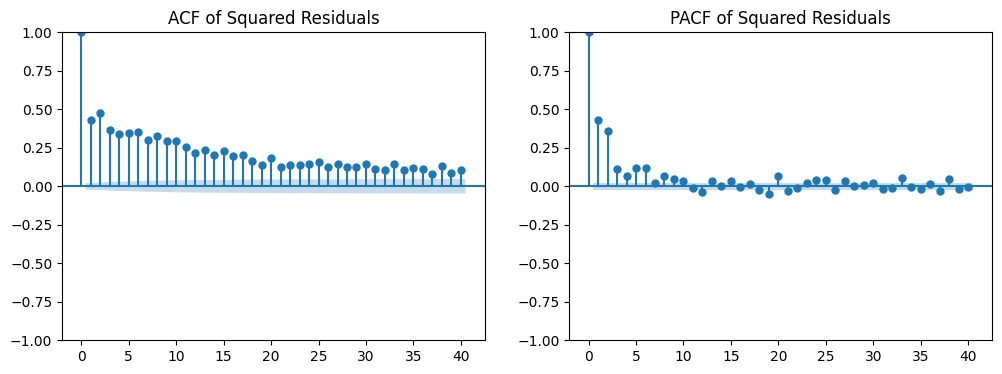

In [37]:

# drop na to prep for getting optimal lags
y = df['sp500_close'].dropna()  # or any other series
y_diff = y.diff().dropna()      # remove trend to get stationarity

# fit basic regression (OLS)
X = sm.add_constant(np.ones(len(y_diff)))
ols_model = sm.OLS(y_diff.values, X).fit()
squared_resid = ols_model.resid**2  # need squared residuals for ACF/PACF

# Plot ACF and PACF of squared residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(squared_resid, lags=40, ax=plt.gca())
plt.title('ACF of Squared Residuals')

plt.subplot(1,2,2)
plot_pacf(squared_resid, lags=40, ax=plt.gca())
plt.title('PACF of Squared Residuals')
plt.show()

In [38]:

# Use returns (daily pct change) and scale
y = df['1d_return_pct'].dropna() # -99 to 100

# ARCH lag selection
max_lag = 30
aic_list, bic_list = [], []

for p in range(1, max_lag + 1):
    am = arch_model(y, vol='ARCH', p=p, o=0, q=0, dist='normal', rescale=True)
    res = am.fit(disp='off')
    aic_list.append(res.aic)
    bic_list.append(res.bic)

# Compile results
arch_lag_selection = pd.DataFrame({
    'lag': range(1, max_lag + 1),
    'AIC': aic_list,
    'BIC': bic_list
})

# Display table
print(arch_lag_selection)

# Optimal lag
optimal_lag_aic = arch_lag_selection.loc[arch_lag_selection['AIC'].idxmin(), 'lag']
optimal_lag_bic = arch_lag_selection.loc[arch_lag_selection['BIC'].idxmin(), 'lag']
print(f"Optimal ARCH lag (AIC): {optimal_lag_aic}")
print(f"Optimal ARCH lag (BIC): {optimal_lag_bic}")

    lag           AIC           BIC
0     1  25483.032586  25504.209743
1     2  24316.951755  24345.187964
2     3  23866.603307  23901.898568
3     4  23454.876569  23497.230883
4     5  23269.160296  23318.573662
5     6  23170.823812  23227.296230
6     7  23099.520448  23163.051918
7     8  23028.744033  23099.334555
8     9  22991.325414  23068.974989
9    10  22955.674405  23040.383032
10   11  22935.756682  23027.524362
11   12  22937.052102  23035.878834
12   13  22926.520377  23032.406161
13   14  22919.074214  23032.019050
14   15  22920.012193  23040.016081
15   16  22917.298065  23044.361006
16   17  22914.540721  23048.662714
17   18  22915.264348  23056.445393
18   19  22902.961405  23051.201503
19   20  22903.469354  23058.768504
20   21  22904.311071  23066.669273
21   22  22905.554617  23074.971871
22   23  22903.287484  23079.763790
23   24  22904.453196  23087.988555
24   25  22902.216811  23092.811222
25   26  22904.216811  23101.870274
26   27  22897.105185  23101

In [39]:
# make a 1, 2, 5 day lag like a VAR model
df[f'return_lag_1'] = df['1d_return'].shift(1) # acf+pacf said 1 day lag is relevant
df[f'return_lag_2'] = df['1d_return'].shift(2) # acf+pacf said 2 day is relevant
df[f'return_lag_11'] = df['1d_return'].shift(11)

# add 5 and 20 day rolling metrics like GARCH
# this is to overcome clustering of volatility metrics
df['roll_mean_5'] = df['1d_return'].rolling(5).mean()
df['roll_std_5'] = df['1d_return'].rolling(5).std()
df['roll_mean_20'] = df['1d_return'].rolling(20).mean()
df['roll_std_20'] = df['1d_return'].rolling(20).std()


In [40]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day', 'sp500_close',
       'sp500_high', 'sp500_low', 'sp500_open', 'sp500_ohlc_volume',
       '5d_return', '20d_return', '200d_return', '1d_return', '1d_return_pct',
       'direction_1d', 'direction_5d', 'direction_20d', 'direction_50d',
       'direction_200d', 'macd', 'macd_signal', 'roc', 'rsi', 'stoch_k',
       'stoch_d', 'adx', 'obv', 'atr', 'bb_upper', 'bb_middle', 'bb_lower',
       'ema_12', 'ema_26', 'sma_20', 'sma_50', 'sma_200', 'return_lag_1',
       'return_lag_2', 'return_lag_11', 'roll_mean_5', 'roll_std_5',
       'roll_mean_20', 'roll_std_20'],
      dtype='object')

BIC indicates we include a lag of 11. The AIC of 30 is pretty extreme so we'll not use that for p. We'll select lag=11 in addition to the lags in the literature.

## Generate descriptive statistics

Calculate and display descriptive statistics for the numerical columns in the DataFrame.


In [41]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day', 'sp500_close',
       'sp500_high', 'sp500_low', 'sp500_open', 'sp500_ohlc_volume',
       '5d_return', '20d_return', '200d_return', '1d_return', '1d_return_pct',
       'direction_1d', 'direction_5d', 'direction_20d', 'direction_50d',
       'direction_200d', 'macd', 'macd_signal', 'roc', 'rsi', 'stoch_k',
       'stoch_d', 'adx', 'obv', 'atr', 'bb_upper', 'bb_middle', 'bb_lower',
       'ema_12', 'ema_26', 'sma_20', 'sma_50', 'sma_200', 'return_lag_1',
       'return_lag_2', 'return_lag_11', 'roll_mean_5', 'roll_std_5',
       'roll_mean_20', 'roll_std_20'],
      dtype='object')

In [42]:
display(df.describe())

,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,sma_20,sma_50,sma_200,return_lag_1,return_lag_2,return_lag_11,roll_mean_5,roll_std_5,roll_mean_20,roll_std_20
count,8597,8597.000000,8597.000000,8.597000e+03,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,...,8577.000000,8547.000000,8397.000000,8595.000000,8594.000000,8585.000000,8592.000000,8592.000000,8577.000000,8577.000000
mean,2007-01-19 10:42:31.866930432,19.560306,1596.652238,2.463780e+09,13662.535273,183.166216,16763.460949,-0.158047,2.690266,2.492381,...,1593.905336,1590.469140,1575.728648,0.000373,0.000372,0.000370,0.000374,0.009273,0.000378,0.009753
min,1990-01-03 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2736.600098,-26.418300,0.000000,1.000000,...,305.832503,310.209802,332.555450,-0.119841,-0.119841,-0.119841,-0.039384,0.000530,-0.016943,0.002072
25%,1998-07-06 00:00:00,13.850000,898.700012,6.467400e+08,8038.570000,63.720000,10722.799805,-0.383563,0.180000,1.000000,...,899.656509,898.510500,923.318249,-0.004487,-0.004487,-0.004489,-0.001887,0.005001,-0.000693,0.006037
50%,2007-01-22 00:00:00,17.730000,1270.199951,2.521000e+09,10846.290000,177.830000,16803.759766,-0.045977,2.300000,2.000000,...,1271.292505,1269.171799,1265.043450,0.000574,0.000573,0.000571,0.000673,0.007567,0.000619,0.008275
75%,2015-08-04 00:00:00,22.960000,2058.899902,3.834320e+09,17635.390000,272.590000,22867.330078,0.247940,4.990000,3.000000,...,2055.047510,2045.883198,2032.405754,0.005717,0.005715,0.005711,0.002929,0.011380,0.001626,0.011692
max,2024-02-16 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,...,4934.692529,4804.354434,4496.905588,0.115800,0.115800,0.115800,0.035898,0.094495,0.010964,0.061182
std,NaN,7.902780,1106.241259,1.847305e+09,9022.864862,133.671305,7350.096474,1.651492,2.296294,1.117501,...,1099.814961,1091.312519,1055.898836,0.011431,0.011431,0.011435,0.004704,0.007049,0.002199,0.006116


## Explore correlations

Calculate and visualize the correlation matrix to understand the relationships between different features.



Correlation Decile Matrix (0 = lowest 10%, 9 = highest 10%):
                   vix  sp500  sp500_volume  djia  djia_volume  hsi  ads  \
vix                  9      1             6     1            6    1    0   
sp500                1      9             7     9            8    8    4   
sp500_volume         6      7             9     8            8    8    0   
djia                 1      9             8     9            8    8    3   
djia_volume          6      8             8     8            9    7    0   
hsi                  1      8             8     8            7    9    2   
ads                  0      4             0     3            0    2    9   
us3m                 1      0             0     0            0    0    5   
joblessness          6      0             1     0            0    0    1   
epu                  7      7             7     7            7    6    0   
GPRD                 5      5             2     5            6    0    1   
prev_day             1    

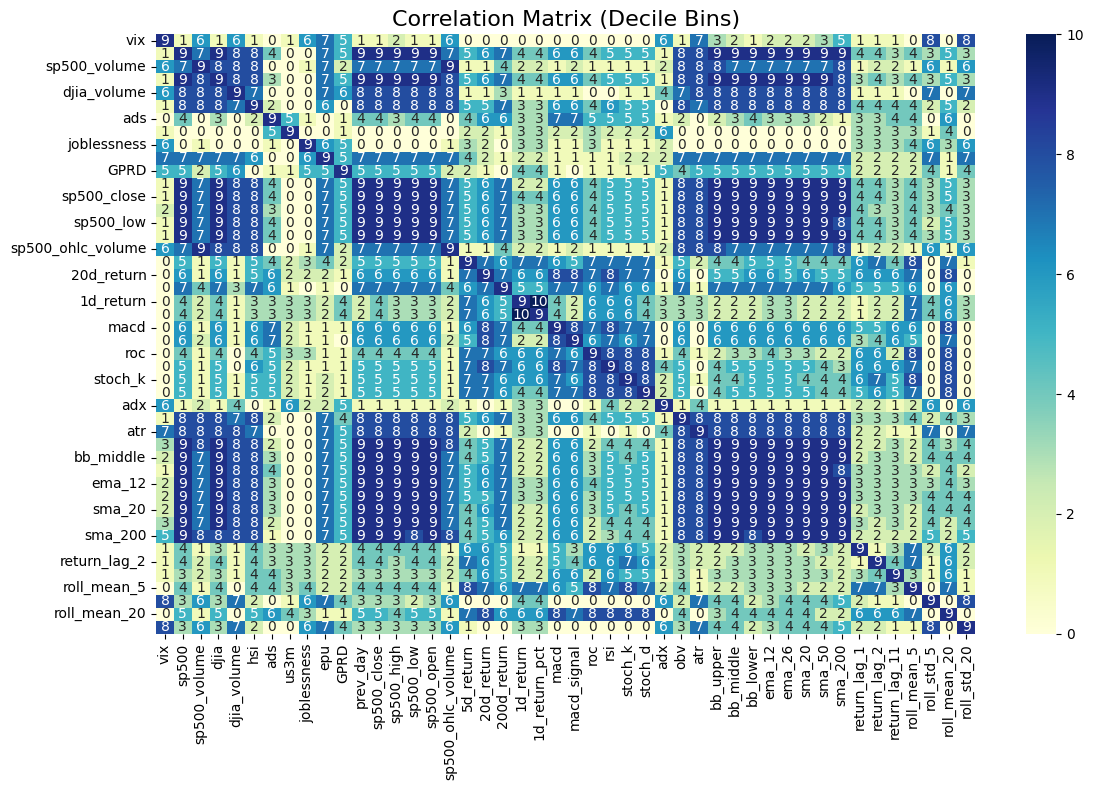

In [43]:
# --- Correlation Matrix ---
corr_matrix = df.corr(numeric_only=True)

# Flatten the matrix to compute decile bins
corr_values = corr_matrix.to_numpy().flatten()

# Compute decile breakpoints (excluding diagonal of 1.0 to avoid skew)
mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
deciles = np.percentile(corr_values[mask.flatten()], np.arange(0, 101, 10))

# Assign each correlation to a decile (0 = lowest 10%, 9 = highest 10%)
def assign_decile(x):
    # np.searchsorted returns which bin the value belongs to
    return np.searchsorted(deciles, x, side="right") - 1

corr_decile = corr_matrix.applymap(assign_decile)

print("\nCorrelation Decile Matrix (0 = lowest 10%, 9 = highest 10%):")
print(corr_decile)

# Optional: heatmap of deciles
plt.figure(figsize=(12, 8))
sns.heatmap(corr_decile, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Correlation Matrix (Decile Bins)", fontsize=16)
plt.tight_layout()
plt.show()

## Visualize target variable distribution

Visualize the distribution of the target variables (1-day, 5-day, and 20-day directions) to understand the class balance.


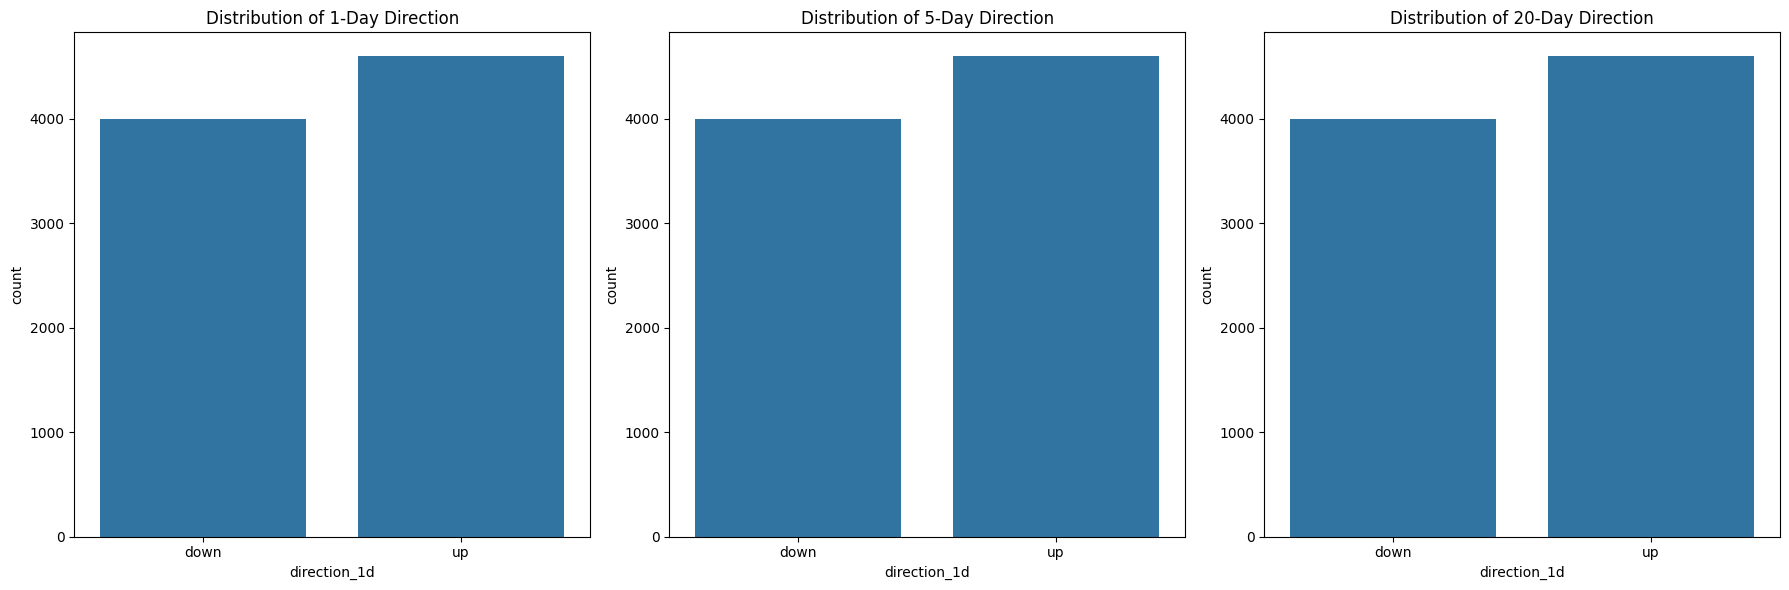

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x='direction_1d', data=df, ax=axes[0])
axes[0].set_title('Distribution of 1-Day Direction')

sns.countplot(x='direction_1d', data=df, ax=axes[1])
axes[1].set_title('Distribution of 5-Day Direction')

sns.countplot(x='direction_1d', data=df, ax=axes[2])
axes[2].set_title('Distribution of 20-Day Direction')

plt.tight_layout()
plt.show()

Columns
* dt: Date of observation in YYYY-MM-DD format.
* vix: VIX (Volatility Index), a measure of expected market volatility.
* sp500: S&P 500 index value, a benchmark of the U.S. stock market.
* sp500_volume: Daily trading volume for the S&P 500.
* djia: Dow Jones Industrial Average (DJIA), another key U.S. market index.
* djia_volume: Daily trading volume for the DJIA.
* hsi: Hang Seng Index, representing the Hong Kong stock market.
* ads: Aruoba-Diebold-Scotti (ADS) Business Conditions Index, reflecting U.S. economic activity.
* us3m: U.S. Treasury 3-month bond yield, a short-term interest rate proxy.
* joblessness: U.S. unemployment rate, reported as quartiles (1 represents lowest quartile and so on).
* epu: Economic Policy Uncertainty Index, quantifying policy-related economic uncertainty.
* GPRD: Geopolitical Risk Index (Daily), measuring geopolitical risk levels.
* prev_day: Previous day’s S&P 500 closing value, added for lag-based time series analysis.
Columns
* sp500_open: open price (USD)
* sp500_high: high price for the day
* sp500_low: low price for the day
* sp500_close: closing price for the day
* sp500_adj_close:
* sp500_ohlc_volume: day trading volume
* 1d_return
* direction_1d
* direction_5d
* direction_20d
* direction_50d
* direction_200d
* macd
* macd_signal
* roc
* rsi
* stoch_k
* stoch_d
* adx
* obv
* atr
* bb_upper
* bb_middle
* bb_lower
* ema_12
* ema_26
* sma_20
* sma_50
* sma_200
* 1d_return_pct
* return_lag_1
* return_lag_2
* return_lag_3
* return_lag_11
* roll_mean_5
* roll_std_5
* roll_mean_20
* roll_std_20

In [45]:
def print_missing_value_counts(df):
  # Count NaNs in any column
  print(df.isna().any(axis=1).sum())

print_missing_value_counts(df)


201


In [46]:
# drop rows with ANY NaN values
df = df.dropna()

# reset the index to clean up
df = df.reset_index(drop=True)

# verify
print_missing_value_counts(df)


0


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score
import numpy as np

# Separate features and target
X = df.drop(columns=['direction_1d', 'direction_5d', 'direction_20d', 'direction_50d', 'direction_200d',
                     'Date', '1d_return', 'sp500', 'sp500_close'])   # predict the next day
y = df['direction_1d']

# Define model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=17,
    oob_score=True,
    n_jobs=-1          # multiproc if possible
)

# 10-fold CV repeated 10 times
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=17)

# Evaluate using accuracy (change 'scoring' if needed)
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)



In [48]:
oob_accuracy = rf.oob_score
print(f"Out-of-Bag (OOB) Accuracy: {oob_accuracy:.4f}")

print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Std Deviation: {scores.std():.4f}")

Out-of-Bag (OOB) Accuracy: 1.0000
Mean Accuracy: 0.5317
Std Deviation: 0.0179
